# Binary Classification of Rice Varieties (Tabular Neural Network)

In this notebook, we build a feedforward neural network to classify rice grains into two varieties (Cammeo (class=0) and Osmancik (class=1)) using tabular morphological features.

The workflow includes:
- Stratified train/validation/test split (70/15/15)
- Feature normalization via `MaxAbsScaler` (fit on training set only)
- Training using mini-batch gradient descent with Adam optimizer
- Evaluation using accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix

The final model achieves ~99% test accuracy, demonstrating strong separability of the dataset.

In [2]:
import numpy as np 
import pandas as pd 
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler


## Reproducibility and selecting the device:

In [3]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


In [4]:
df = pd.read_csv("riceClassification.csv")
df

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18180,18181,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,18182,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,18183,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,18184,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


##### Dropping any column that contains any missing values, and the 'id' column

In [5]:
df.dropna(how='any', inplace=True)
df.drop(columns=["id"], inplace=True)
df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...
18180,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


We split the dataset into training (70%), validation (15%), and test (15%) sets.
Feature scaling is then applied using `MaxAbsScaler`.

The scaler is fitted **only on the training data** and subsequently used to transform the validation and test sets. 
This prevents data leakage and ensures a fair evaluation.

Scaling helps normalize feature magnitudes, improving numerical stability and allowing the neural network to train more effectively.

In [6]:
X = df.drop(columns=["Class"]).astype(np.float32).to_numpy()
y = df["Class"].astype(np.float32).to_numpy()

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True, stratify=y_temp
)

print("Split sizes:", len(X_train), len(X_val), len(X_test))

Split sizes: 12729 2728 2728


In [8]:
scaler = MaxAbsScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

### PyTorch Dataset and DataLoader

We wrap the scaled NumPy arrays into a custom `Dataset` class to make them compatible with PyTorch's `DataLoader`.  
The `DataLoader` handles batching, shuffling (for training), and efficient data feeding during mini-batch gradient descent.

In [9]:
# This class wraps our NumPy arrays into a format compatible with DataLoader.
# It converts features and labels into torch tensors. 

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        # reshaping the tensors to (N,1) since BCEWithLogitsLoss expects 
        # labels of shape (batch_size, 1)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] 

In [10]:
batch_size = 64

# Creating Dataset objects for each split
train_ds = TabularDataset(X_train_s, y_train)
val_ds = TabularDataset(X_val_s, y_val)
test_ds = TabularDataset(X_test_s, y_test)

# Creating DataLoaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

### Neural Network Architecture

We use a simple fully connected feedforward neural network with:
- One hidden layer (32 neurons)
- ReLU activation (introducing non-linearity)
- A single output neuron producing logits

The model is trained using `BCEWithLogitsLoss`, which combines a sigmoid activation with binary cross-entropy in a numerically stable way.

In [11]:
class RiceNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

In [12]:
model = RiceNet(input_dim=X_train_s.shape[1], hidden_dim=32).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Batch Accuracy Computation

Since the model outputs logits (raw scores), we apply a sigmoid function during evaluation to obtain probabilities.  
A threshold of 0.5 is used to convert probabilities into binary class predictions.

In [13]:
@torch.no_grad()
def batch_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits)
    preds = (probs >= 0.5).float()
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct, total

### Training and Validation Loop

For each epoch:
- The model is trained using mini-batch gradient descent.
- Loss is computed using `BCEWithLogitsLoss`.
- Model parameters are updated via the Adam optimizer.
- Validation is performed without gradient computation to evaluate generalization performance.

In [14]:
epochs = 15
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_sum, total_sum = 0, 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        c, t = batch_accuracy_from_logits(logits, labels)
        correct_sum += c
        total_sum += t

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_sum / total_sum 

    model.eval()
    val_running_loss = 0.0
    val_correct_sum, val_total_sum = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            loss = criterion(logits, labels)
            val_running_loss += loss.item()
            c, t = batch_accuracy_from_logits(logits, labels)
            val_correct_sum += c
            val_total_sum += t

    val_loss = val_running_loss / len(val_loader)
    val_acc = 100 * val_correct_sum / val_total_sum

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d}/{epochs} | "
          f"Train loss {train_loss:.4f} Acc {train_acc:.2f}% | "
          f"Val loss {val_loss:.4f} Acc {val_acc:.2f}%")

Epoch 01/15 | Train loss 0.6525 Acc 74.91% | Val loss 0.5904 Acc 95.93%
Epoch 02/15 | Train loss 0.4972 Acc 96.95% | Val loss 0.3915 Acc 97.80%
Epoch 03/15 | Train loss 0.3023 Acc 97.89% | Val loss 0.2260 Acc 98.46%
Epoch 04/15 | Train loss 0.1806 Acc 98.22% | Val loss 0.1438 Acc 98.46%
Epoch 05/15 | Train loss 0.1227 Acc 98.26% | Val loss 0.1043 Acc 98.50%
Epoch 06/15 | Train loss 0.0938 Acc 98.37% | Val loss 0.0831 Acc 98.79%
Epoch 07/15 | Train loss 0.0777 Acc 98.45% | Val loss 0.0710 Acc 98.79%
Epoch 08/15 | Train loss 0.0679 Acc 98.44% | Val loss 0.0636 Acc 98.94%
Epoch 09/15 | Train loss 0.0615 Acc 98.47% | Val loss 0.0574 Acc 98.90%
Epoch 10/15 | Train loss 0.0570 Acc 98.51% | Val loss 0.0546 Acc 98.86%
Epoch 11/15 | Train loss 0.0544 Acc 98.47% | Val loss 0.0510 Acc 98.86%
Epoch 12/15 | Train loss 0.0513 Acc 98.49% | Val loss 0.0480 Acc 98.90%
Epoch 13/15 | Train loss 0.0496 Acc 98.48% | Val loss 0.0464 Acc 98.86%
Epoch 14/15 | Train loss 0.0484 Acc 98.50% | Val loss 0.0469 Acc

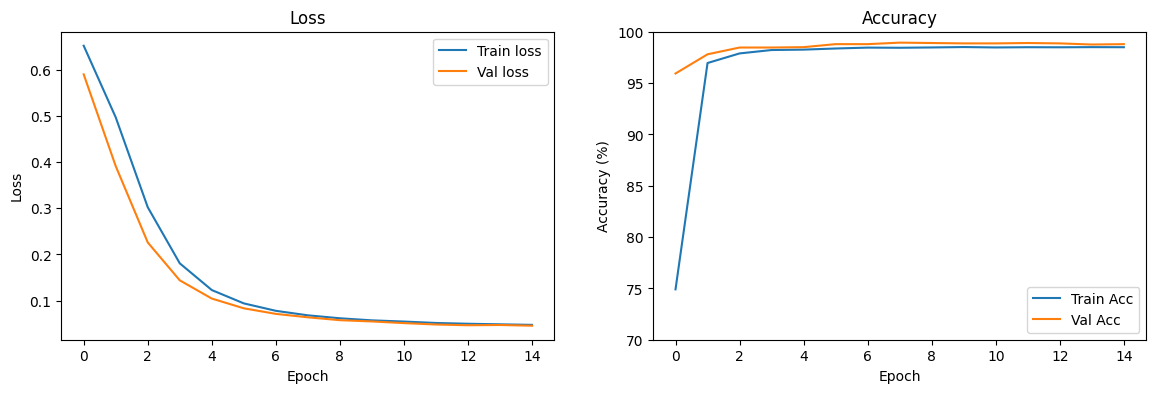

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

ax[0].plot(train_losses, label="Train loss")
ax[0].plot(val_losses, label="Val loss")
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(train_accs, label="Train Acc")
ax[1].plot(val_accs, label="Val Acc")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim(70, 100)
ax[1].legend()

plt.show()

In [16]:
model.eval()
test_running_loss = 0.0
test_correct_sum, test_total_sum = 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)
        loss = criterion(logits, labels)

        test_running_loss += loss.item()
        c, t = batch_accuracy_from_logits(logits, labels)
        test_correct_sum += c
        test_total_sum += t

test_loss = test_running_loss / len(test_loader)
test_acc = 100 * test_correct_sum / test_total_sum
print(f"\n TEST | Loss: {test_loss:.4f} | Acc: {test_acc:.2f}%")


 TEST | Loss: 0.0416 | Acc: 98.97%


In [24]:
target_col = "Class"
feature_cols = [col for col in df.columns if col != target_col]

def predict_one_raw_feature_values(raw_feature_dict):
    # build raw feature vector in correct column order
    raw_x = np.array([raw_feature_dict[c] for c in feature_cols], dtype=np.float32)

    # sklearn expects 2D: (1, num_features)
    raw_x = raw_x.reshape(1, -1)

    # scale using the fitted scaler
    x_scaled = scaler.transform(raw_x)

    # convert to torch tensor
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x_tensor)
        prob = torch.sigmoid(logits).item()
        pred_class = 1 if prob >= 0.5 else 0

    return prob, pred_class

In [25]:
row_i = 34 # you can check the predcition for any row you want
raw_dict = {c: float(df.loc[row_i, c]) for c in feature_cols}

prob, pred = predict_one_raw_feature_values(raw_dict)

print("\nExample A: predict dataset row", row_i)
print("True class:", int(df.loc[row_i, "Class"]))
print("Pred prob(Class=1):", prob)
print("Pred class:", pred)


Example A: predict dataset row 34
True class: 1
Pred prob(Class=1): 0.8181613087654114
Pred class: 1


In [27]:
@torch.no_grad()
def collect_probs_preds_labels(model, loader, device, threshold=0.5):
    model.eval()
    probs_list, preds_list, labels_list = [], [], []

    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)
        probs = torch.sigmoid(logits).squeeze(1)         
        preds = (probs >= threshold).long()               
        labels = labels.squeeze(1).long()                     

        probs_list.append(probs.numpy())
        preds_list.append(preds.numpy())
        labels_list.append(labels.numpy())

    probs = np.concatenate(probs_list)
    preds = np.concatenate(preds_list)
    labels = np.concatenate(labels_list)
    return probs, preds, labels

In [28]:
test_probs, test_preds, test_labels = collect_probs_preds_labels(model, test_loader, device, threshold=0.5)

              precision    recall  f1-score   support

           0     0.9902    0.9870    0.9886      1230
           1     0.9893    0.9920    0.9907      1498

    accuracy                         0.9897      2728
   macro avg     0.9898    0.9895    0.9896      2728
weighted avg     0.9897    0.9897    0.9897      2728



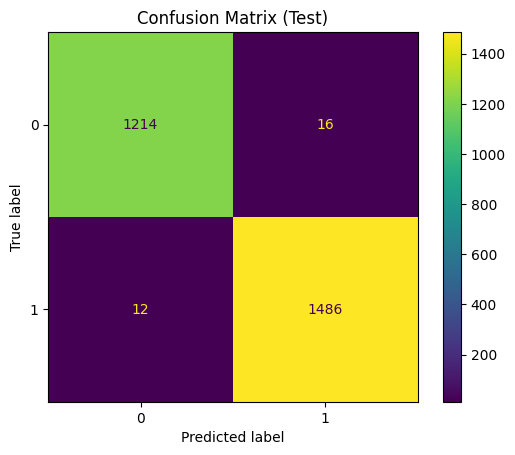

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(test_labels, test_preds, digits=4))

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()

ROC-AUC: 0.9991
PR-AUC : 0.9992


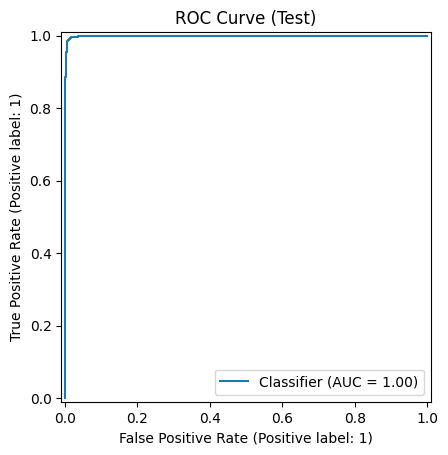

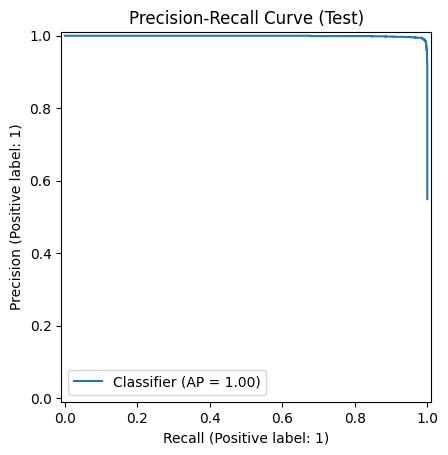

In [30]:
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay

roc_auc = roc_auc_score(test_labels, test_probs)
pr_auc  = average_precision_score(test_labels, test_probs)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")

RocCurveDisplay.from_predictions(test_labels, test_probs)
plt.title("ROC Curve (Test)")
plt.show()

PrecisionRecallDisplay.from_predictions(test_labels, test_probs)
plt.title("Precision-Recall Curve (Test)")
plt.show()

In [31]:
import joblib

# Save in current folder (no directories needed)
joblib.dump(scaler, "maxabs_scaler.joblib")

joblib.dump(
    {
        "feature_cols": feature_cols,
        "target_col": target_col,
        # edit to your real class names if you want:
        "class_map": {0: "Class 0", 1: "Class 1"},
        "hidden_dim": 32
    },
    "metadata.joblib"
)

torch.save(model.state_dict(), "rice_model.pt")

print("Saved: maxabs_scaler.joblib, metadata.joblib, rice_model.pt")

Saved: maxabs_scaler.joblib, metadata.joblib, rice_model.pt
